In [1]:
import pandas as pd

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import seaborn as sns

In [162]:
import keras
from keras.layers import Dense,BatchNormalization,Dropout, SimpleRNN, Embedding, LSTM, ConvLSTM2D, Flatten, BatchNormalization, Conv1D, Conv2D
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import Adam,SGD

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
!unzip occupancy_data.zip

--2020-12-24 16:13:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335713 (328K) [application/x-httpd-php]
Saving to: ‘occupancy_data.zip.2’

occupancy_data.zip. 100%[===================>] 327.84K  --.-KB/s    in 0.1s    

2020-12-24 16:13:26 (2.71 MB/s) - ‘occupancy_data.zip.2’ saved [335713/335713]

Archive:  occupancy_data.zip
replace datatest.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: datatest.txt            
replace datatest2.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: datatest2.txt           
replace datatraining.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: datatraining.txt        


In [4]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from datetime import datetime
data = pd.read_csv("datatraining.txt",engine='python')
data['Date']=pd.to_datetime(data['date'])
data.drop(columns='date',inplace=True)
data=data.set_index(pd.date_range(start=datetime(2015, 2, 4, 17, 51), end = datetime(2015,2,10, 9, 33), freq = 'T'))
#data.drop(columns='Date',inplace=True)
data.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Date
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,2015-02-04 17:51:00
2015-02-04 17:52:00,23.15,27.2675,429.5,714.00,0.004783,1,2015-02-04 17:51:59
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,2015-02-04 17:53:00
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,2015-02-04 17:54:00
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,2015-02-04 17:55:00


(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 8 Text major ticklabel objects>)

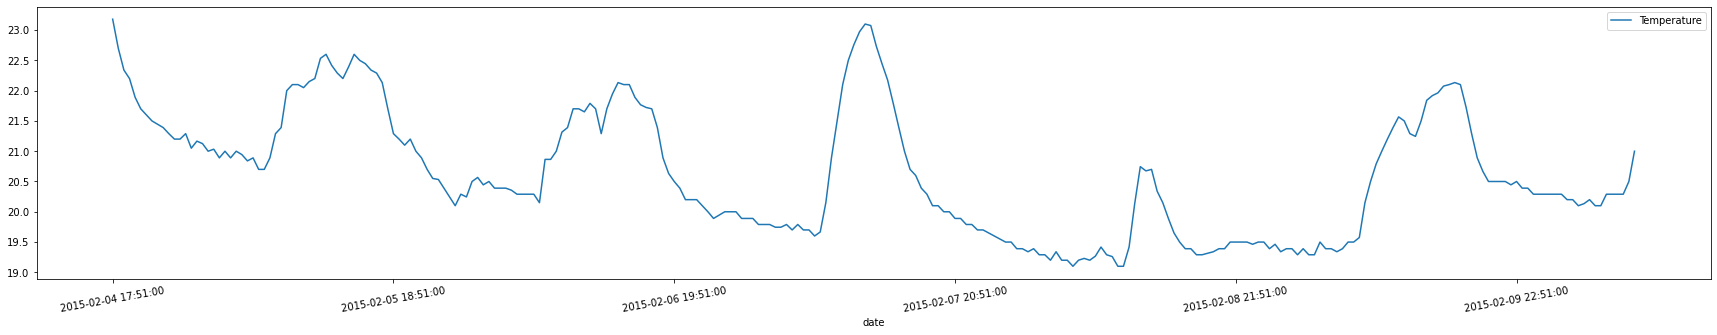

In [68]:
data = pd.read_csv("datatraining.txt",engine='python')

data.reset_index(inplace=True)
data['Date']=pd.to_datetime(data['date'])
data=data.set_index(pd.date_range(start=datetime(2015, 2, 4, 17, 51), end = datetime(2015,2,10, 9, 33), freq = 'T'))
data['temperature'] = data['Temperature'] * 10
st = []
for i in range(0, len(data), 30):
  st.append(i)

data = data.iloc[st, : ]
data.plot('date','Temperature', figsize = (30, 5))
plt.xticks(rotation=10)

In [69]:
data

,index,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Date,temperature
2015-02-04 17:51:00,1,2015-02-04 17:51:00,23.18,27.272000,426.0,721.250000,0.004793,1,2015-02-04 17:51:00,231.8
2015-02-04 18:21:00,31,2015-02-04 18:21:00,22.70,27.463333,0.0,668.666667,0.004688,0,2015-02-04 18:21:00,227.0
2015-02-04 18:51:00,61,2015-02-04 18:51:00,22.34,27.390000,0.0,626.500000,0.004573,0,2015-02-04 18:51:00,223.4
2015-02-04 19:21:00,91,2015-02-04 19:21:00,22.20,27.200000,0.0,577.000000,0.004502,0,2015-02-04 19:21:00,222.0
2015-02-04 19:51:00,121,2015-02-04 19:51:00,21.89,27.100000,0.0,551.500000,0.004401,0,2015-02-04 19:51:00,218.9
...,...,...,...,...,...,...,...,...,...,...
2015-02-10 07:21:00,8011,2015-02-10 07:21:00,20.29,33.045000,0.0,450.500000,0.004868,0,2015-02-10 07:21:00,202.9
2015-02-10 07:51:00,8041,2015-02-10 07:51:00,20.29,33.045000,0.0,449.000000,0.004868,0,2015-02-10 07:51:00,202.9
2015-02-10 08:21:00,8071,2015-02-10 08:21:00,20.29,33.126667,0.0,450.000000,0.004880,0,2015-02-10 08:21:00,202.9
2015-02-10 08:51:00,8101,2015-02-10 08:51:00,20.50,33.722500,407.5,495.500000,0.005034,1,2015-02-10 08:51:00,205.0


In [52]:
data.Temperature

0       23.18
30      22.70
60      22.34
90      22.20
120     21.89
        ...  
8010    20.29
8040    20.29
8070    20.29
8100    20.50
8130    21.00
Name: Temperature, Length: 272, dtype: float64

## Проверка стационарности и STL-декомпозиция ряда:

In [70]:
s = 48

Критерий Дики-Фуллера: p=0.009253


<Figure size 1080x720 with 0 Axes>

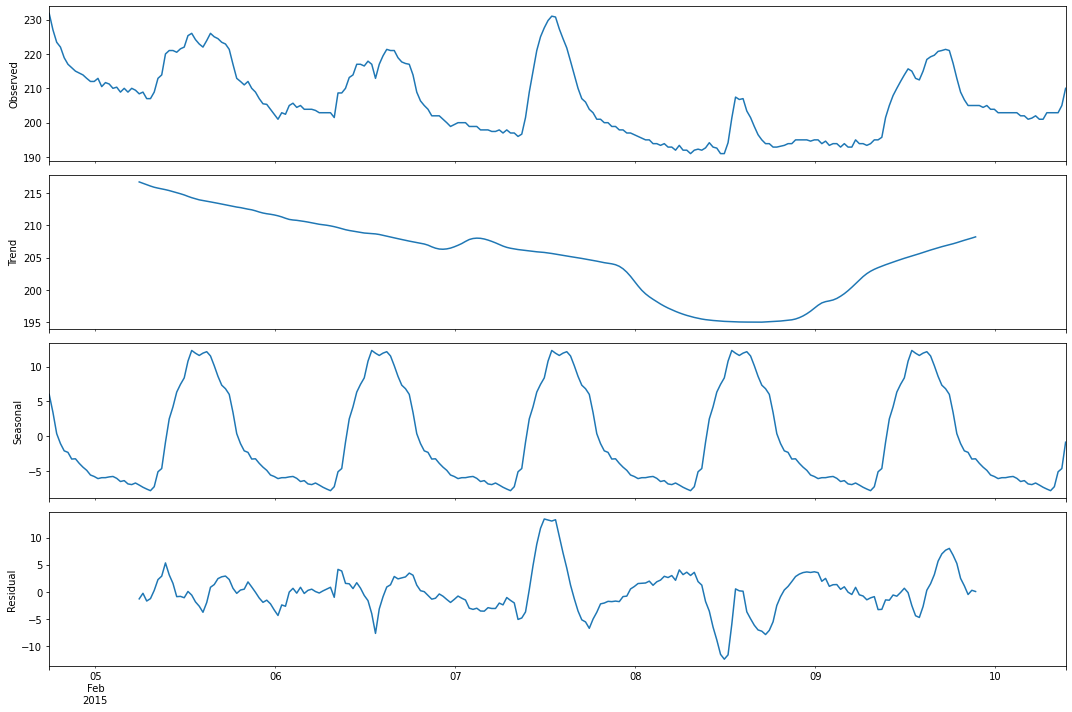

In [71]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.temperature, model='additive', freq = s).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.temperature)[1])

## Сезонное дифференцирование

Критерий Дики-Фуллера: p=0.145323


<Figure size 1080x720 with 0 Axes>

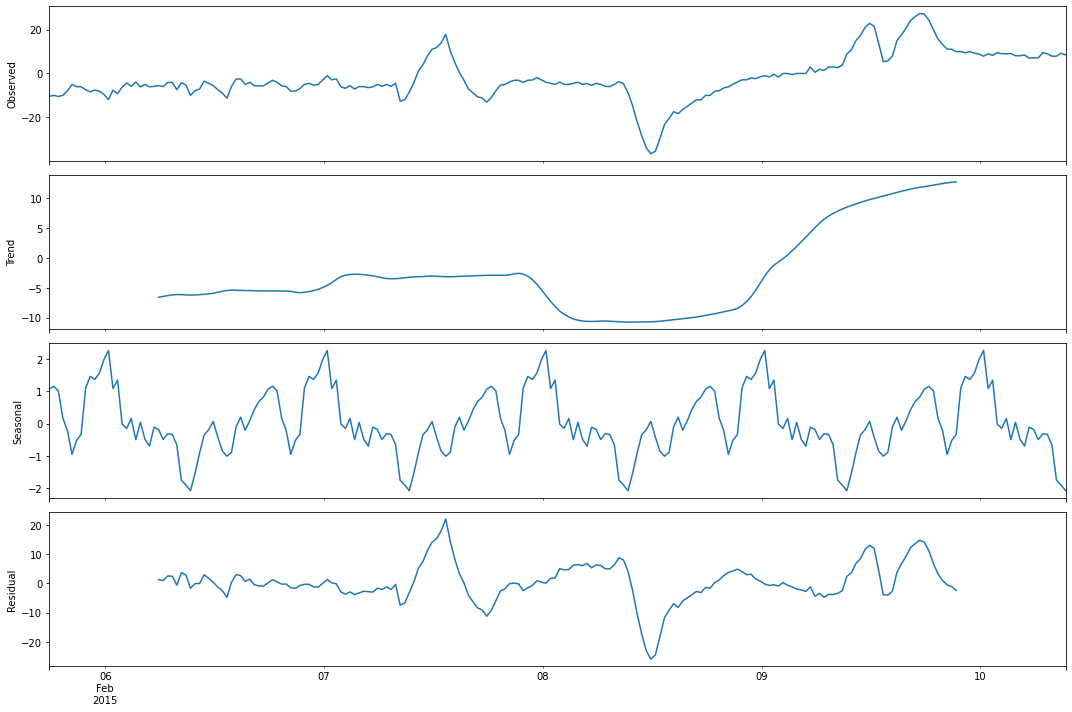

In [72]:
data['temperature_diff'] = data.temperature - data.temperature.shift(s)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.temperature_diff[s:], freq = s).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.temperature_diff[s:])[1])

## Обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

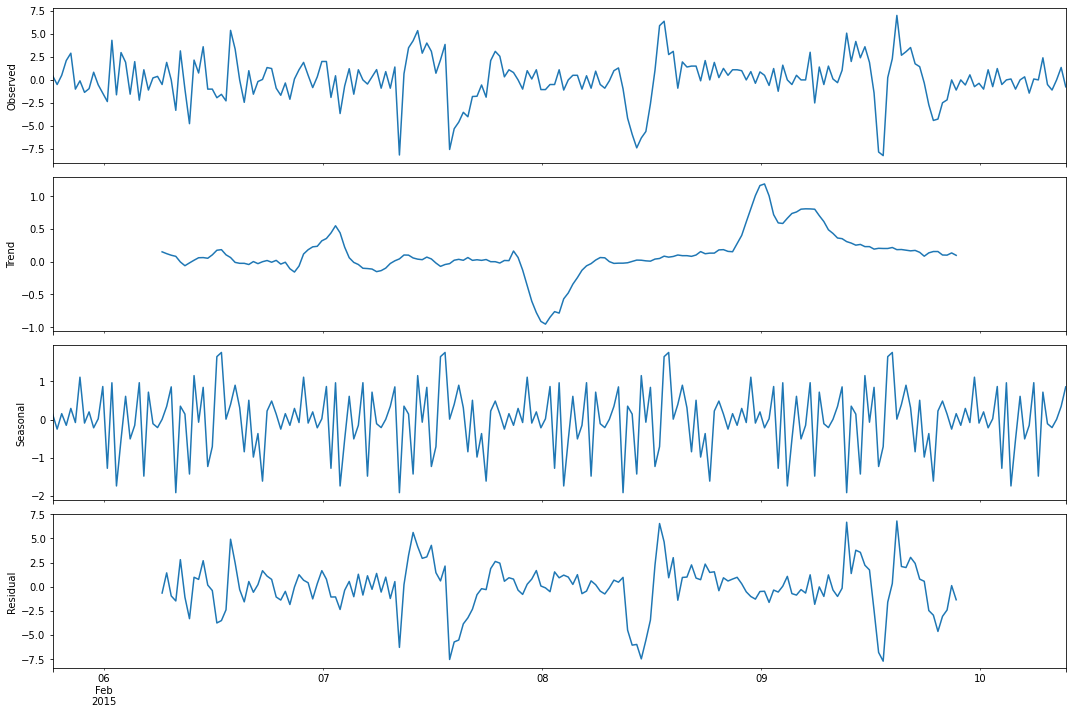

In [73]:
data['temperature_diff2'] = data.temperature_diff - data.temperature_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.temperature_diff2[s + 1:], freq = s + 1).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.temperature_diff2[s+1:])[1])

## Подбор модели

### ACF и PACF полученного ряда

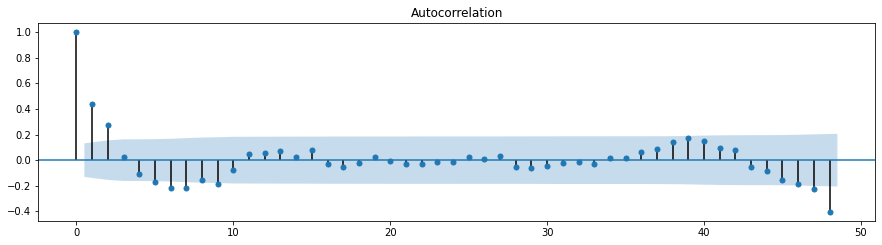

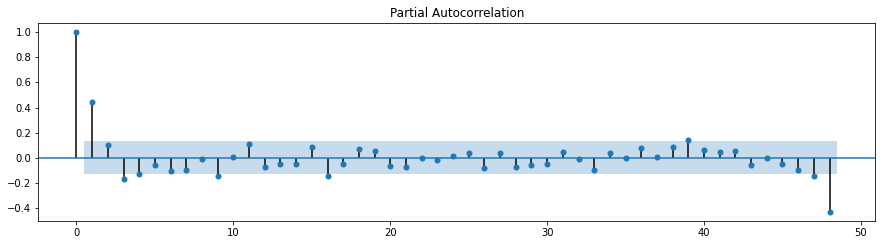

In [74]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.temperature_diff2[s+1:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.temperature_diff2[s+1:].values.squeeze(), lags=48, ax=ax)
pylab.show()

## Начальные приближения

In [59]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [60]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

## Определение оптимальной модели

In [61]:
%%time

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.temperature.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 44min 34s, sys: 16min 42s, total: 1h 1min 16s
Wall time: 31min 9s


In [62]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
41  (3, 1, 0, 1)  892.636394
53  (4, 1, 0, 1)  894.573730
45  (3, 2, 0, 1)  894.578243
43  (3, 1, 1, 1)  894.634907
57  (4, 2, 0, 1)  896.082424


## Предсказание

In [121]:
train = data.temperature[:235]
test = data.temperature[235 :]

In [122]:
train

2015-02-04 17:51:00    231.80
2015-02-04 18:21:00    227.00
2015-02-04 18:51:00    223.40
2015-02-04 19:21:00    222.00
2015-02-04 19:51:00    218.90
                        ...  
2015-02-09 12:51:00    215.00
2015-02-09 13:21:00    212.90
2015-02-09 13:51:00    212.45
2015-02-09 14:21:00    215.00
2015-02-09 14:51:00    218.40
Freq: 30T, Name: temperature, Length: 235, dtype: float64

In [123]:
best_model=sm.tsa.statespace.SARIMAX(train.values, order=(3, d, 1), 
                                        seasonal_order=(0, D, 1, s)).fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


In [124]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  235
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 48)   Log Likelihood                -380.566
Date:                            Thu, 24 Dec 2020   AIC                            773.133
Time:                                    19:58:55   BIC                            792.487
Sample:                                         0   HQIC                           780.976
                                            - 235                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1426      0.105     10.843      0.000       0.936       1.349
ar.L2         -0.1080      0.115   

Критерий Стьюдента: p=0.307169
Критерий Дики-Фуллера: p=0.000000


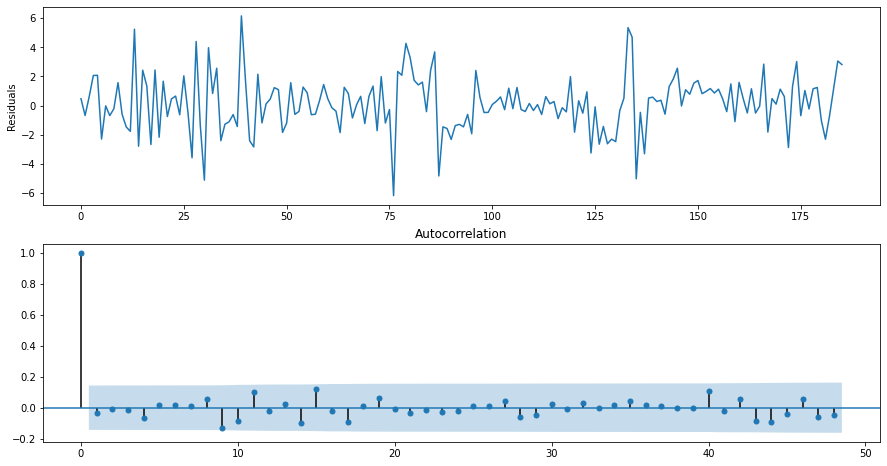

In [125]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(best_model.resid[s + 1:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[s + 1:].squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[s+1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[s+1:])[1])

In [129]:
len(data)

272

In [130]:
len(train)

235

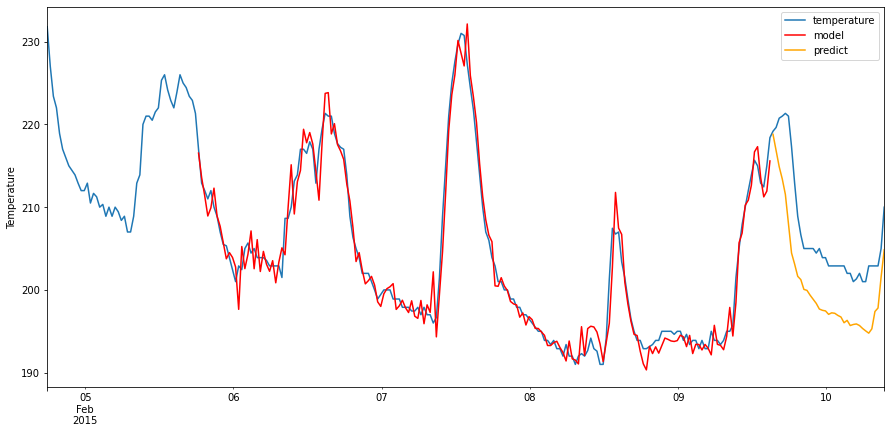

In [138]:
data['model'] =  list(best_model.fittedvalues) +  (len(data) - len(train)) * [np.nan]
data['predict'] = len(train) * [None] + list(best_model.predict(start=len(train) + 1, end=272))
plt.figure(figsize(15,7))
data.temperature.plot(legend = 'temperature')
data.model[s + 1:].plot(color='r', legend = 'train' )
data.predict.plot(color='orange', legend = 'test')
plt.ylabel('Temperature')
pylab.show()

# Оцениваем качество с помощью метрик RMSE и MAE

In [224]:
def RMSE(predicted, actual):
    se = (predicted - actual)**2
    mse = se.sum() / se.count()
    rmse = np.sqrt(mse)
    return rmse

def MAE(predicted, actual):
    se = np.abs((predicted - actual))
    mae = se.sum() / se.count()
    return mae

In [222]:
RMSE_test = RMSE(best_model.predict(start=len(train) + 1, end=272), data.temperature.iloc[len(train) : ])
RMSE_train = RMSE(best_model.fittedvalues[s+1:], data.temperature.iloc[s+1 :len(train) ])

In [225]:
MAE_train = MAE(best_model.fittedvalues[s+1:], data.temperature.iloc[s+1 :len(train) ])
MAE_test = MAE(best_model.predict(start=len(train) + 1, end=272), data.temperature.iloc[len(train) : ])

In [226]:
print(f'RMSE train = {RMSE_train}')
print(f'RMSE test = {RMSE_test}')

RMSE train = 1.9037816793493636
RMSE test = 6.726316523806764


In [228]:
print(f'MAE train = {MAE_train}')
print(f'MAE test = {MAE_test}')

MAE train = 1.4418606162809584
MAE test = 6.334358917070828
